<a id="0"></a>


 <center><img src='https://i.imgur.com/MSRc2v3.jpg' 
     height=150px width=1150px /></center> 
     


# 🌟 **Sentiment Analysis on Tweets** 🌟
In this notebook, we'll be performing **Sentiment Analysis** on a dataset containing **tweets** to classify the sentiments into **positive**, **neutral**, and **negative** categories.

The process involves several steps including **data preprocessing**, **visualizations**, and **model training** using different algorithms. Let's walk through each step in detail. 🚀


## 📊 Dataset Description 📑

This dataset consists of tweets, which we will be analyzing and preprocessing for sentiment analysis. Below is a description of the key features in the dataset:

| **Column Name**     | **Description**                                                                                 | **Data Type**     |
|---------------------|-------------------------------------------------------------------------------------------------|-------------------|
| `tweet`             | The actual tweet text.                                                                          | `String`          |
| `char_count`        | The number of characters in the tweet.                                                           | `Integer`         |
| `word_count`        | The number of words in the tweet.                                                                | `Integer`         |
| `stopwords`         | The count of stopwords in the tweet.                                                             | `Integer`         |
| `hastags`           | The count of hashtags in the tweet.                                                              | `Integer`         |
| `numerics`          | The count of numeric values in the tweet.                                                        | `Integer`         |
| `sentiment`         | The sentiment label of the tweet, usually indicating positive, negative, or neutral.            | `Categorical`     |

### Dataset Information
- **Number of rows**: 27,481 (example size)
- **Target variable**: `sentiment` (classification task)
- **Data Collection Source**: Twitter API (https://www.kaggle.com/datasets/yasserh/twitter-tweets-sentiment-dataset/data)

The dataset includes a combination of textual, numerical, and categorical features, which will be cleaned, analyzed, and used for further sentiment prediction tasks.


## 📚 1. Importing Libraries and Loading Data 🧑‍💻
We begin by importing the required libraries and loading the dataset. 📊


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import string
from tqdm import tqdm
from multiprocessing import Pool
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, \
roc_auc_score, roc_curve, precision_score, recall_score

import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Loading the dataset 
df = pd.read_csv('/kaggle/input/twitter-tweets-sentiment-dataset/Tweets.csv')
#Let's check the samples of data
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


## 🧹 2. Data Preprocessing ✨
In this step, we will perform data cleaning by:
- Dropping irrelevant columns ❌
- Handling missing values ❓


In [3]:
# Let's drop selected_text & text ID column
df.drop(['selected_text', 'textID'], axis=1, inplace=True)
target = 'sentiment'
df.reset_index(drop=True, inplace=True)  # Resetting the index
original_df = df.copy(deep=True)

# Check the dimensions of the dataset
print('Dimensions of dataset:', df.shape)
df.info()  # Checking the dtypes of all the columns
df.describe()  # Descriptive summary of dataset


Dimensions of dataset: (27481, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27481 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB


,text,sentiment
count,27480,27481
unique,27480,3
top,"I`d have responded, if I were going",neutral
freq,1,11118


In [4]:
df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


## 🧽 4. Null and Duplicate Value Check 🔍
In this step, we will:

- Check for missing values 🛑
- Remove rows with missing values 🚮
- Identify and remove duplicates 🔄

In [5]:
# Checking for Null values
df.isnull().sum()

# Dropping the null values
df.dropna(inplace=True)
original_df = df.copy()

# Checking for Duplicates
df.duplicated().sum()


0

 <p style="font-size:20px; font-family:verdana; line-height: 1.7em"> The dataset has one null row, we can drop it</p>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em"> No duplicate values found</p>

## ✨ 5. Feature Engineering 🛠️
In this step, we will:

- Extract useful features such as word count, character count, average word length, etc.
- Calculate additional attributes like stopword count and hashtag count 🌟

In [6]:
# Let's get a word count 
df['word_count'] = df['text'].apply(lambda x: len(str(x).split(" ")))

# Number of Characters (including spaces)
df['char_count'] = df['text'].str.len()

# Average Word Length
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words) / len(words))

df['avg_word'] = df['text'].apply(lambda x: avg_word(x))

# Number of Stop Words
nltk.download('stopwords')
stop = stopwords.words('english')

df['stopwords'] = df['text'].apply(lambda x: len([x for x in x.split() if x in stop]))

# Number of hashtags
df['hastags'] = df['text'].apply(lambda x: len([x for x in x.split() if x.startswith('@')]))

# Number of numerics
df['numerics'] = df['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))


[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


## 🌈 6. Visualize WordCloud for Each Sentiment 💬
In this step, we will:

- Generate WordClouds for each sentiment category (Positive, Negative, Neutral) 🌥️

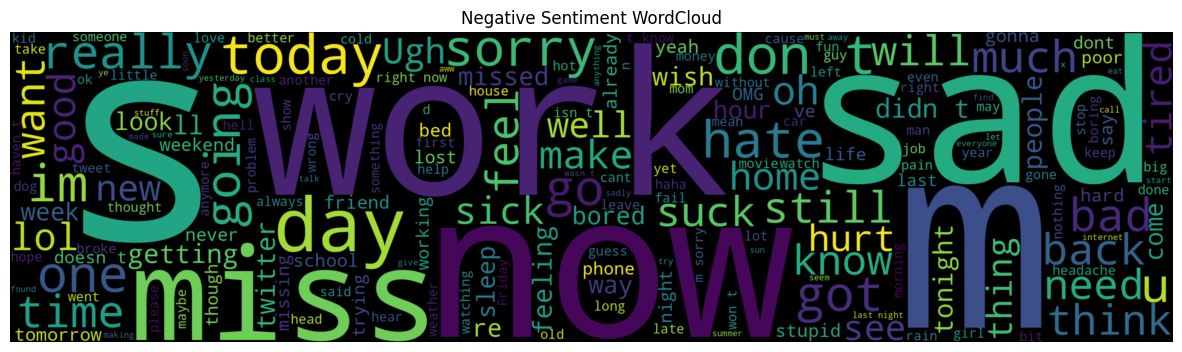

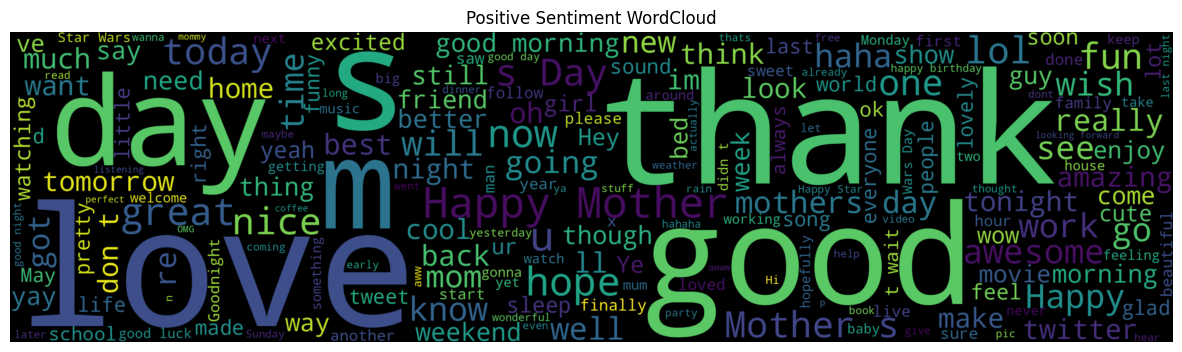

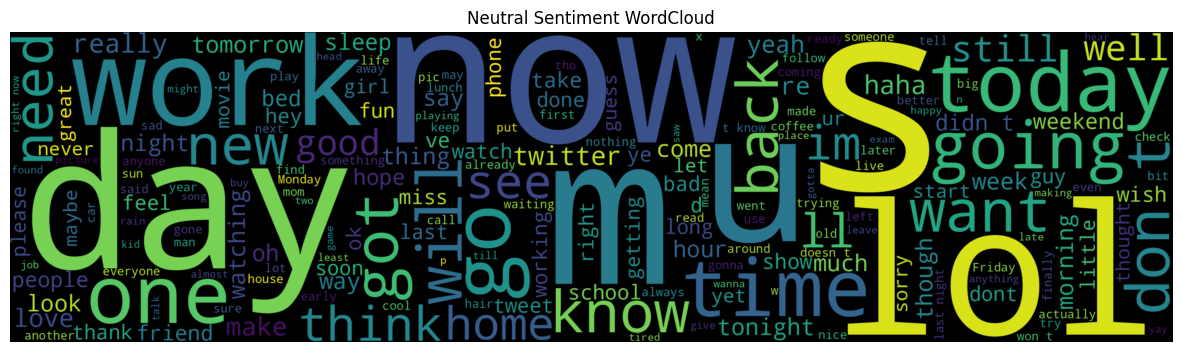

In [7]:
# Install WordCloud
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

# Split the dataframe by sentiment
negative_df = df[df['sentiment'] == 'negative']
positive_df = df[df['sentiment'] == 'positive']
neutral_df = df[df['sentiment'] == 'neutral']

# Define a function to generate and display a WordCloud
def generate_wordcloud(data, title):
    words = ' '.join(data['text'])
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                            and not word.startswith('@')
                            and word != 'RT' ])
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', 
                          width=3000, height=800).generate(cleaned_word)
    plt.figure(figsize=(15, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate and display WordClouds for each sentiment category
generate_wordcloud(negative_df, 'Negative Sentiment WordCloud')
generate_wordcloud(positive_df, 'Positive Sentiment WordCloud')
generate_wordcloud(neutral_df, 'Neutral Sentiment WordCloud')


## 📝 7. Text Preprocessing - Lowercase, Punctuation Removal 🔧
In this step, we will:

- Convert all text to lowercase 🔡
- Remove unwanted punctuation 🚫
- Clean the text by eliminating stopwords 🧹

In [8]:
# Convert text to lowercase
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Removal of punctuations
df['text'] = df['text'].str.replace('[^\w\s]', '')

# Removal of stop words
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

df.head()


,text,sentiment,word_count,char_count,avg_word,stopwords,hastags,numerics
0,"i`d responded, going",neutral,8,36,4.142857,3,0,0
1,sooo sad miss san diego!!!,negative,11,46,3.600000,4,0,0
2,boss bullying me...,negative,5,25,4.200000,2,0,0
3,interview! leave alone,negative,6,31,5.200000,2,0,0
4,"sons ****, couldn`t put releases already bought",negative,15,75,4.357143,7,0,0


## 🧹 8. Frequency Removal & Stemming 🌿
In this step, we will:

- Remove rare words (low frequency) ❌
- Apply stemming to reduce words to their base form 🔄

In [9]:
# Rare Words Removal
freq = pd.Series(' '.join(df['text']).split()).value_counts()[:30]
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

# Rare words frequency
freq = pd.Series(' '.join(df['text']).split()).value_counts()[-10:]
freq

# Stemming
st = PorterStemmer()
df['text'] = df['text'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
df.head()


,text,sentiment,word_count,char_count,avg_word,stopwords,hastags,numerics
0,"i`d responded,",neutral,8,36,4.142857,3,0,0
1,sooo sad miss san diego!!!,negative,11,46,3.600000,4,0,0
2,boss bulli me...,negative,5,25,4.200000,2,0,0
3,interview! leav alon,negative,6,31,5.200000,2,0,0
4,"son ****, couldn`t put releas alreadi bought",negative,15,75,4.357143,7,0,0


## 📊 9. Sentiment Distribution Visualization 📉
In this step, we will:

- Visualize the distribution of sentiments (Positive, Negative, Neutral) using a pie chart 🥧

                 Sentiment Variable Distribution                  


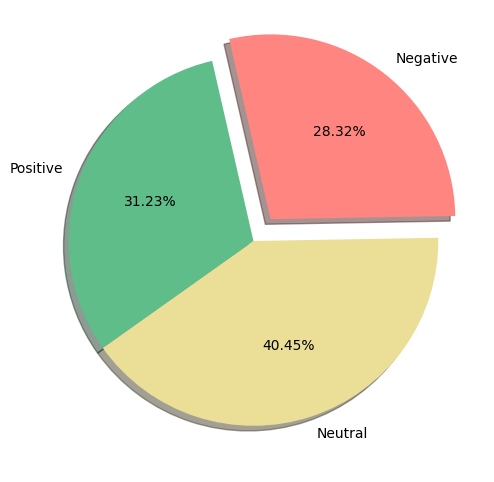

In [10]:
# Let's look at the overall distribution of positive, negative and neutral sentiments
print('\033[1mSentiment Variable Distribution'.center(70))
plt.figure(figsize=(12, 6))
colors = ['#ebde96', '#5ebd89', '#ff8680']
plt.pie(df[target].value_counts(), labels=['Neutral', 'Positive', 'Negative'], counterclock=False, shadow=True,
        explode=[0, 0, 0.15], autopct='%1.2f%%', radius=1, startangle=1, colors=colors)

plt.show()


## 📊 10. Word Frequency Distribution 📈
In this step, we will:

- Visualize the most frequent words in the dataset using a bar plot 🔠

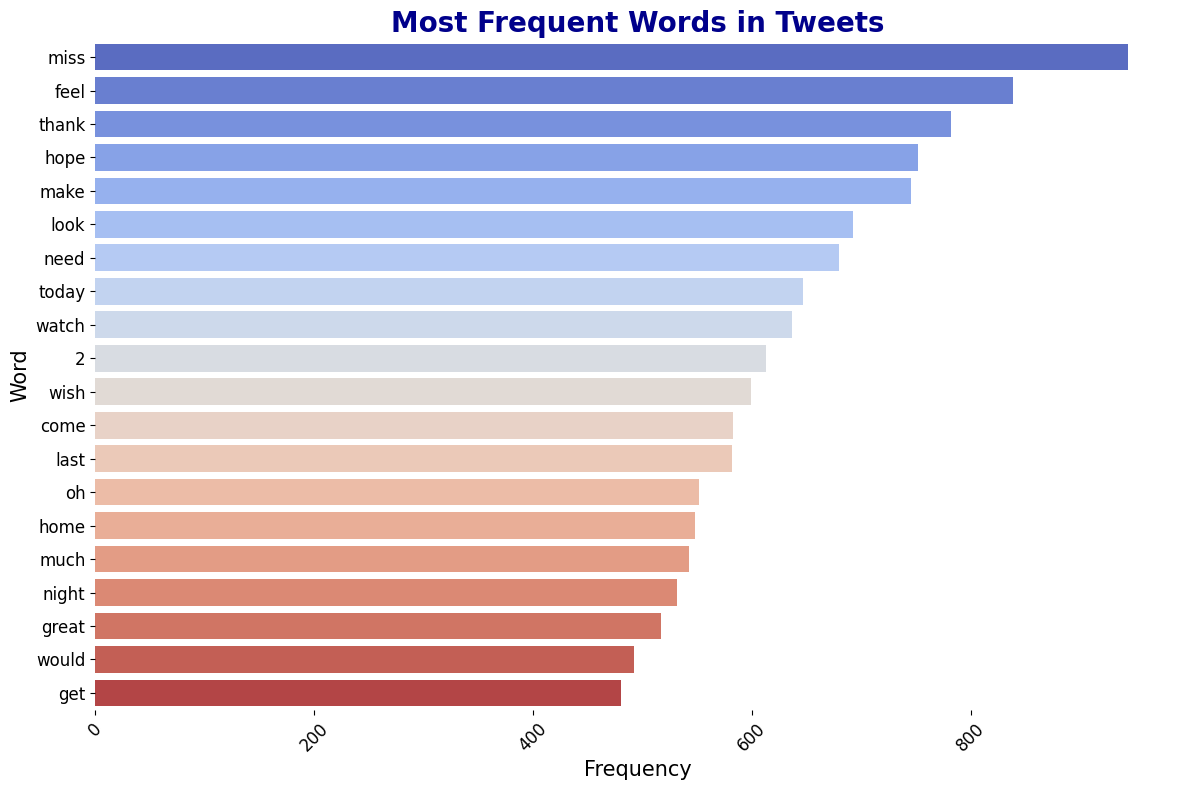

In [11]:
# Frequency Distribution of Words
from collections import Counter

# Get the list of all words
words = ' '.join(df['text']).split()

# Count frequency of each word
word_counts = Counter(words)

# Get the most common words
common_words = word_counts.most_common(20)

# Convert to DataFrame
common_words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

# Frequency Distribution of Words with Beautiful Styling
plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='Word', data=common_words_df, palette='coolwarm')
plt.title('Most Frequent Words in Tweets', fontsize=20, fontweight='bold', color='darkblue')
plt.xlabel('Frequency', fontsize=15, fontweight='light')
plt.ylabel('Word', fontsize=15, fontweight='light')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()



## 📉 11. Text Length Distribution 📏
In this step, we will:

- Visualize the distribution of text lengths (number of characters per tweet) using a histogram 📊

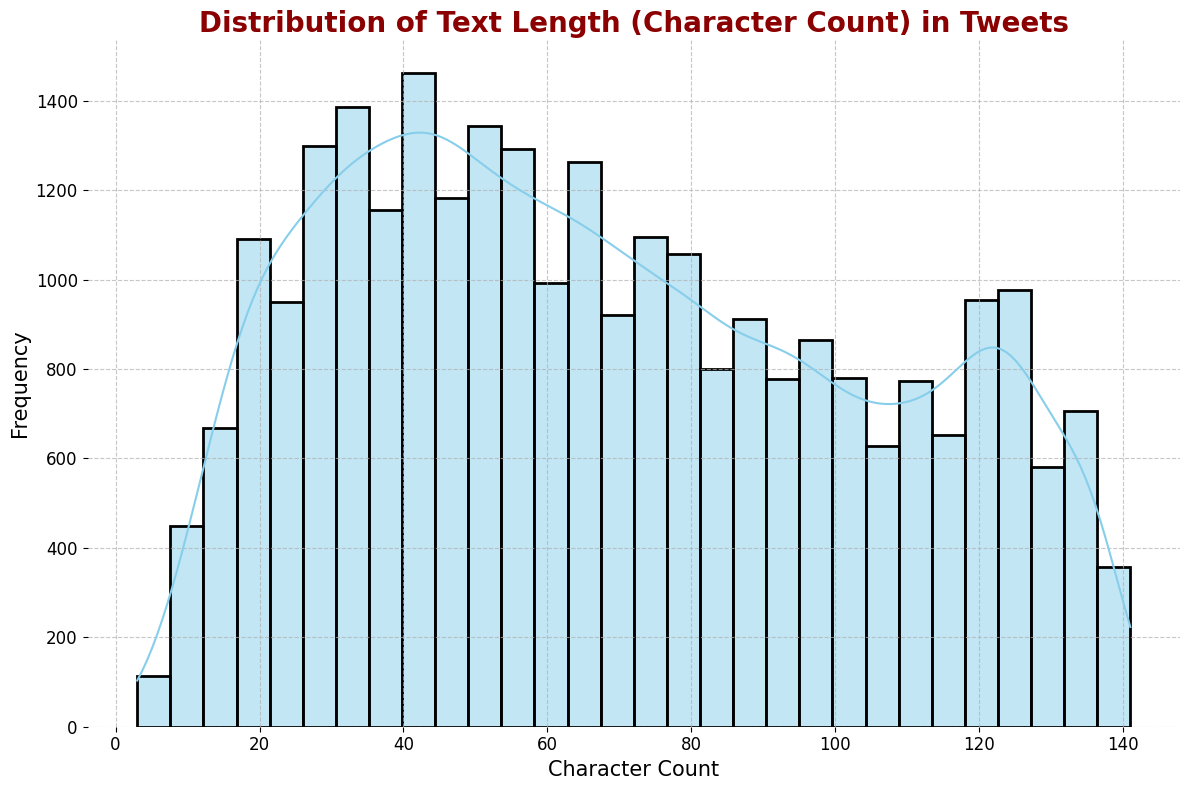

In [12]:
# Plotting Text Length Distribution with Enhanced Styling
plt.figure(figsize=(12, 8))
sns.histplot(df['char_count'], kde=True, color='skyblue', bins=30, linewidth=2, edgecolor='black')
plt.title('Distribution of Text Length (Character Count) in Tweets', fontsize=20, fontweight='bold', color='darkred')
plt.xlabel('Character Count', fontsize=15, fontweight='light')
plt.ylabel('Frequency', fontsize=15, fontweight='light')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


## 📊 11. Word Count Distribution 📝
In this step, we will:

- Visualize the distribution of the number of words per tweet using a histogram 📊

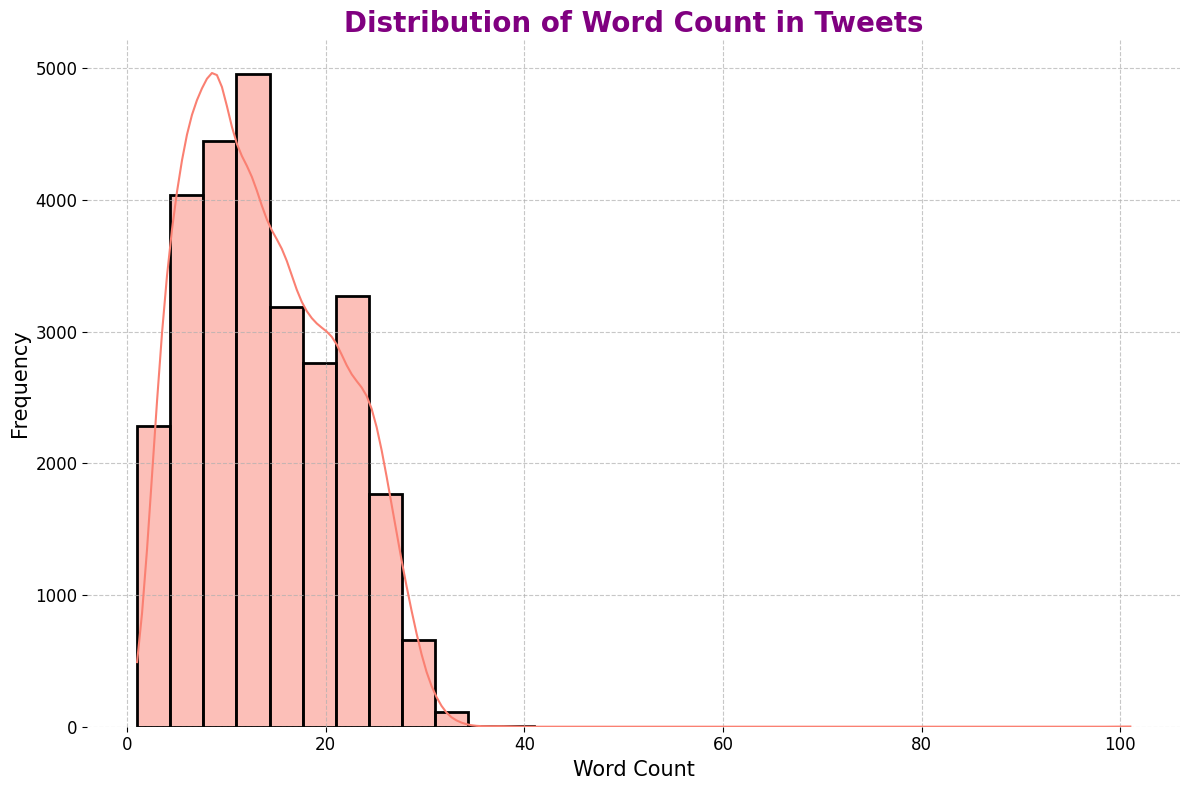

In [13]:
# Plotting Word Count Distribution with Beautiful Styling
plt.figure(figsize=(12, 8))
sns.histplot(df['word_count'], kde=True, color='salmon', bins=30, linewidth=2, edgecolor='black')
plt.title('Distribution of Word Count in Tweets', fontsize=20, fontweight='bold', color='purple')
plt.xlabel('Word Count', fontsize=15, fontweight='light')
plt.ylabel('Frequency', fontsize=15, fontweight='light')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


## 🧮 12. Stopword Count Distribution 🧹
In this step, we will:

- Visualize the number of stopwords in each tweet using a bar plot 🔄

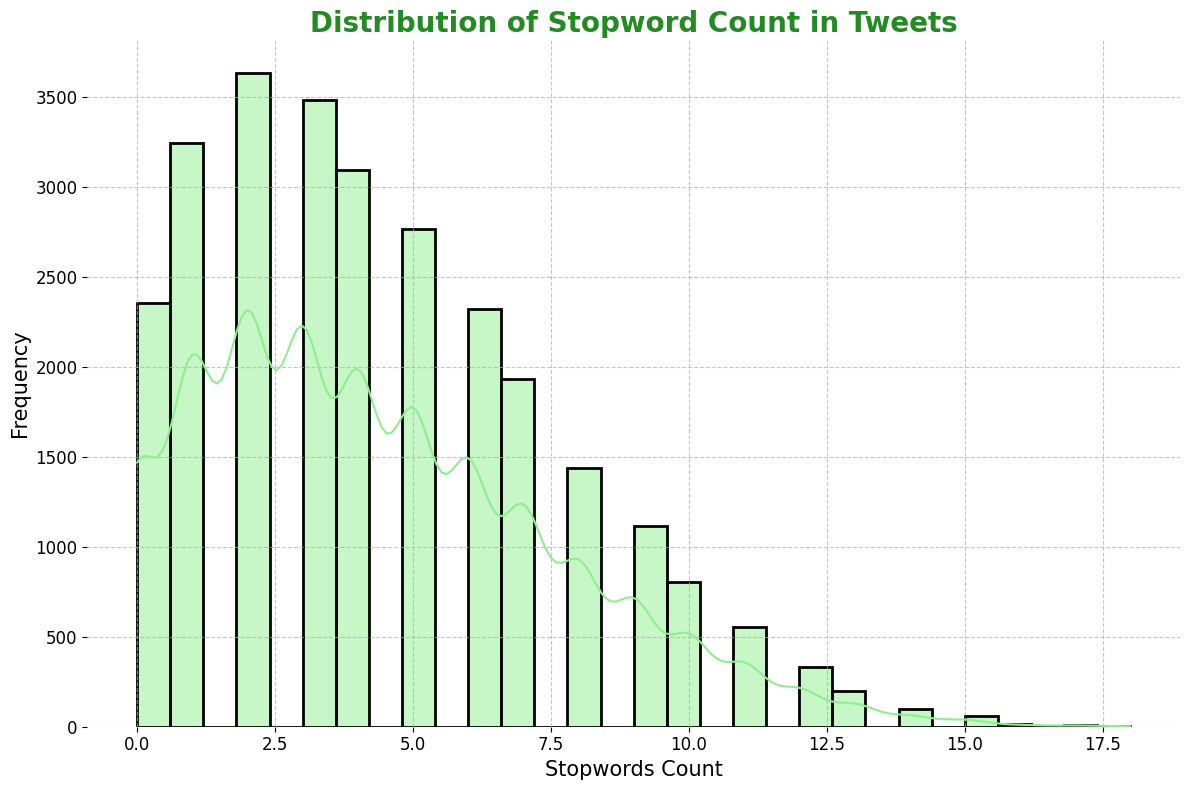

In [14]:
# Plotting Stopword Count Distribution with Enhanced Design
plt.figure(figsize=(12, 8))
sns.histplot(df['stopwords'], kde=True, color='lightgreen', bins=30, linewidth=2, edgecolor='black')
plt.title('Distribution of Stopword Count in Tweets', fontsize=20, fontweight='bold', color='forestgreen')
plt.xlabel('Stopwords Count', fontsize=15, fontweight='light')
plt.ylabel('Frequency', fontsize=15, fontweight='light')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


## 🌐 13. Hashtag Count Distribution 🔖
In this step, we will:

- Visualize the number of hashtags in each tweet using a bar plot 📊

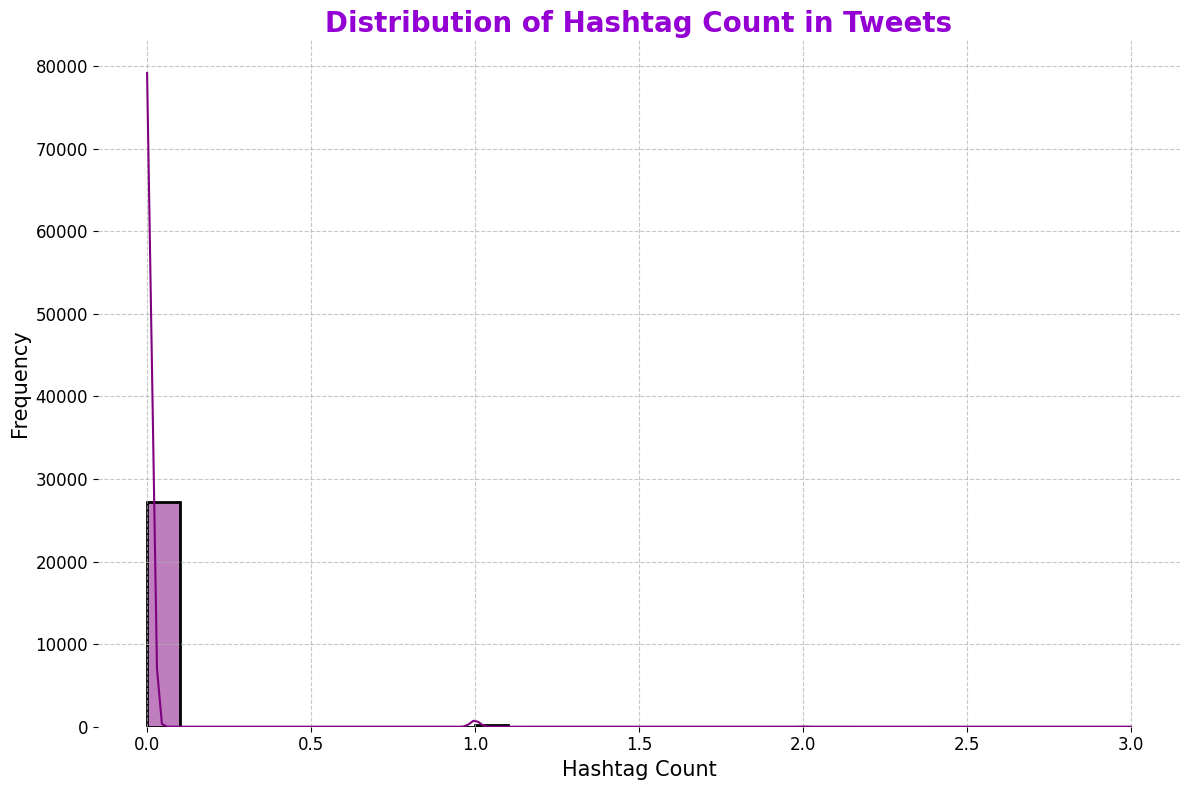

In [15]:
# Plotting Hashtag Count Distribution with Beautiful Styling
plt.figure(figsize=(12, 8))
sns.histplot(df['hastags'], kde=True, color='purple', bins=30, linewidth=2, edgecolor='black')
plt.title('Distribution of Hashtag Count in Tweets', fontsize=20, fontweight='bold', color='darkviolet')
plt.xlabel('Hashtag Count', fontsize=15, fontweight='light')
plt.ylabel('Frequency', fontsize=15, fontweight='light')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


## ⚖️ 14. Numeric Count Distribution 🔢
In this step, we will:

- Visualize the number of numeric values (e.g., numbers, digits) in each tweet using a bar plot 🔢

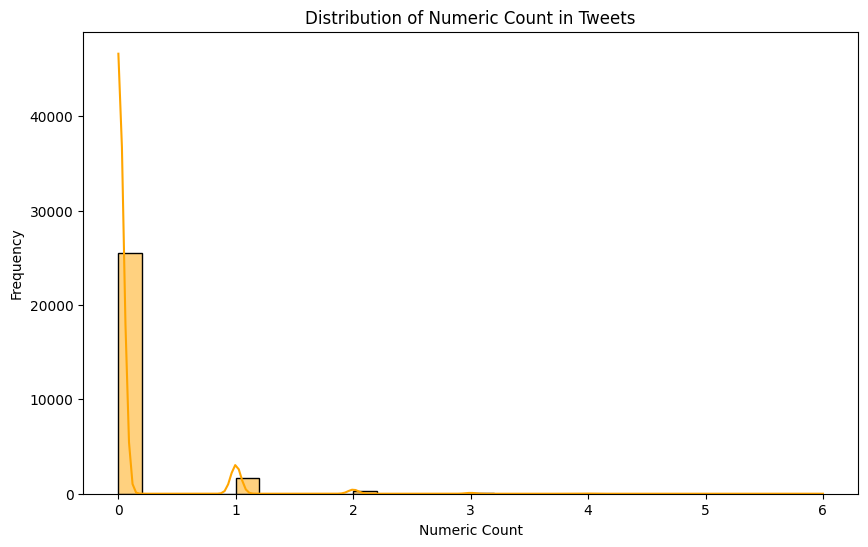

In [16]:
# Plotting Numeric Count Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['numerics'], kde=True, color='orange', bins=30)
plt.title('Distribution of Numeric Count in Tweets')
plt.xlabel('Numeric Count')
plt.ylabel('Frequency')
plt.show()


## 🔤 15. WordCloud for Most Frequent Words 🌥️
In this step, we will:

- Generate a WordCloud for the most frequent words in the dataset 💬



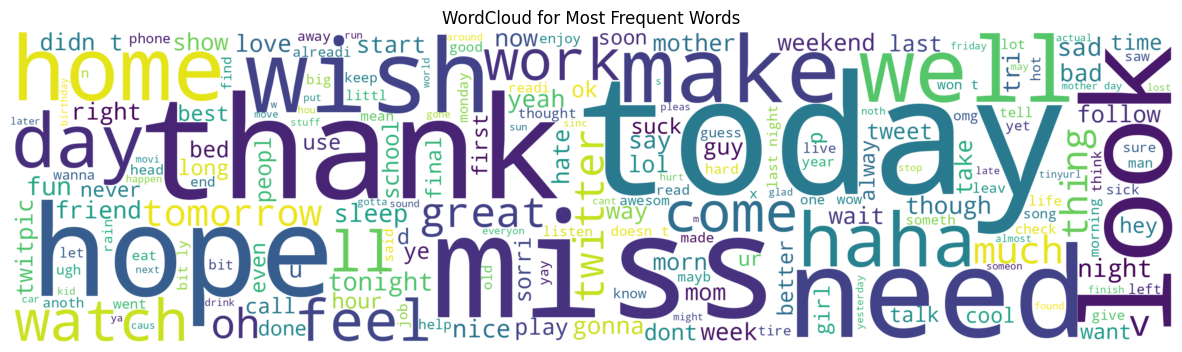

In [17]:
# WordCloud for Most Frequent Words
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', width=3000, height=800).generate(' '.join(words))

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('WordCloud for Most Frequent Words')
plt.axis('off')
plt.show()


## 🔄 16. Correlation Between Features 🔗
In this step, we will:

- Visualize correlations between numerical features (e.g., word count, character count, stopword count, etc.) using a heatmap 🔥



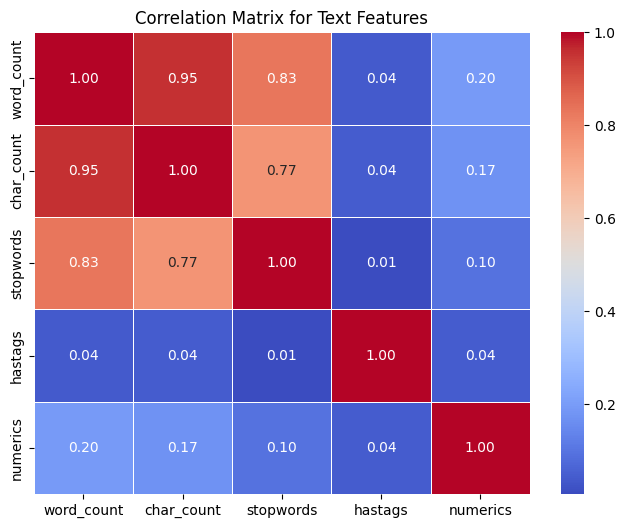

In [18]:
# Correlation Matrix for Numerical Features
correlation_matrix = df[['word_count', 'char_count', 'stopwords', 'hastags', 'numerics']].corr()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix for Text Features')
plt.show()


## 📑 17. Distribution of Sentiments 🎭
In this step, we will:

- Visualize the distribution of the target sentiment variable (Positive, Negative, Neutral) using a bar plot 📊

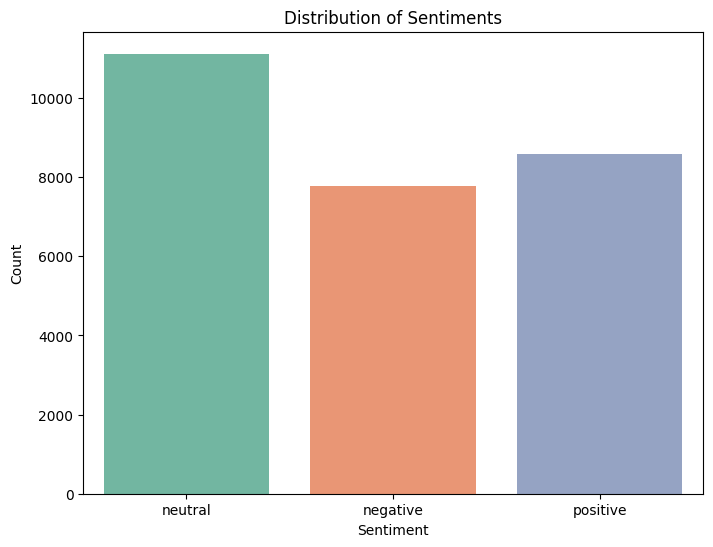

In [19]:
# Plotting Sentiment Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, palette='Set2')
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


## 📉 18. Sentiment Distribution by Length 🔢
In this step, we will:

- Visualize how the text length (in characters) varies across different sentiment categories 📊



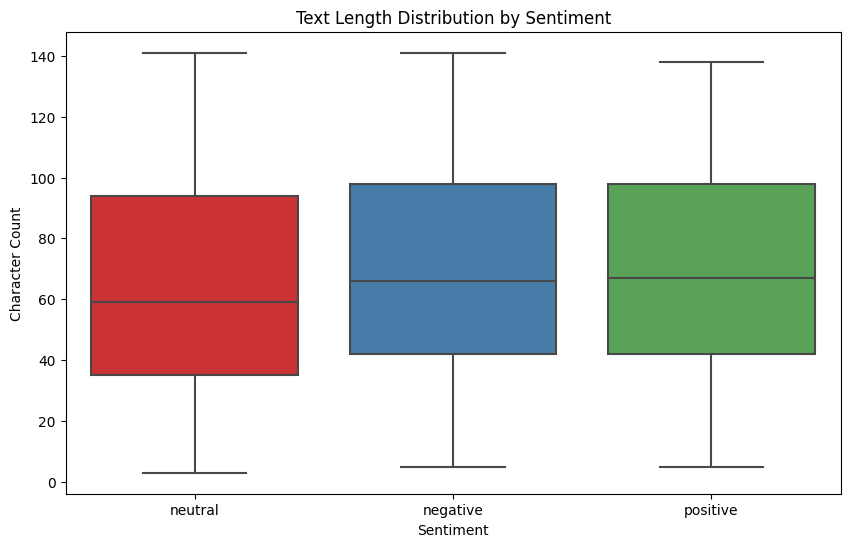

In [20]:
# Sentiment Distribution by Text Length
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='char_count', data=df, palette='Set1')
plt.title('Text Length Distribution by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Character Count')
plt.show()


## 💬 19. Sentiment Distribution by Word Count 🧮
In this step, we will:

- Visualize how the word count varies across different sentiment categories 📊


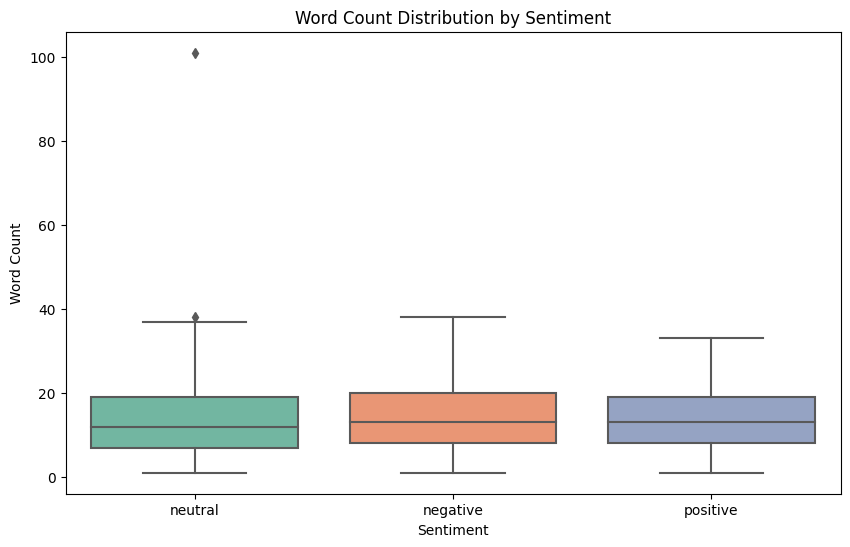

In [21]:
# Sentiment Distribution by Word Count
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='word_count', data=df, palette='Set2')
plt.title('Word Count Distribution by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Word Count')
plt.show()


## 1️⃣ 20. TF-IDF Vectorization and Train-Test Split
We will:

- Convert the text data into numerical form using TF-IDF vectorization to capture the importance of words.
- Split the dataset into training and test sets for model evaluation.

In [22]:
## 🧪 7. Feature Extraction and Train-Test Split 🧹

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)  # Limiting features for efficiency
X = vectorizer.fit_transform(df['text']).toarray()
y = df['sentiment']

# Encoding the target variable
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")


Training data shape: (21984, 5000)
Test data shape: (5496, 5000)


# 🚀 21. Model Evaluation with Advanced Techniques ✨

In this step, we will:
- Train and evaluate **multiple machine learning models**, including advanced models like **XGBoost**, **LightGBM**, and **Gradient Boosting**.
- Use a variety of evaluation metrics:
  - **Accuracy**: Measures the overall correctness of the model.
  - **Precision**: Focuses on the positive predictive values.
  - **Recall**: Emphasizes the model's ability to capture all relevant instances.
  - **F1 Score**: A harmonic mean of precision and recall.
  - **AUC (Area Under Curve)**: Highlights the model's capability to differentiate between classes.
- Display the results in a sorted table 📊 for easy comparison.

This step ensures we compare the performance of both traditional and advanced models, enabling us to select the most suitable one for our sentiment analysis project. 🚦


🔄 Training Models:   0%|          | 0/8 [00:00<?, ?it/s]

🛠️ Training Model: Logistic Regression


🔄 Training Models:  12%|█▎        | 1/8 [00:46<05:28, 46.92s/it]

🛠️ Training Model: Naïve Bayes


🔄 Training Models:  25%|██▌       | 2/8 [00:48<02:02, 20.37s/it]

🛠️ Training Model: Support Vector Classifier


🔄 Training Models:  38%|███▊      | 3/8 [5:50:47<13:19:56, 9599.36s/it]

🛠️ Training Model: Random Forest


🔄 Training Models:  50%|█████     | 4/8 [5:57:42<6:38:14, 5973.51s/it] 

🛠️ Training Model: Decision Tree


🔄 Training Models:  62%|██████▎   | 5/8 [6:06:00<3:19:57, 3999.26s/it]

🛠️ Training Model: Gradient Boosting


🔄 Training Models:  75%|███████▌  | 6/8 [6:30:26<1:44:35, 3137.91s/it]

🛠️ Training Model: XGBoost


🔄 Training Models:  88%|████████▊ | 7/8 [6:31:49<35:39, 2139.07s/it]  

🛠️ Training Model: LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.123685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34600
[LightGBM] [Info] Number of data points in the train set: 21984, number of used features: 1161
[LightGBM] [Info] Start training from score -1.264315
[LightGBM] [Info] Start training from score -0.906401
[LightGBM] [Info] Start training from score -1.159663


🔄 Training Models: 100%|██████████| 8/8 [6:31:56<00:00, 2939.62s/it]


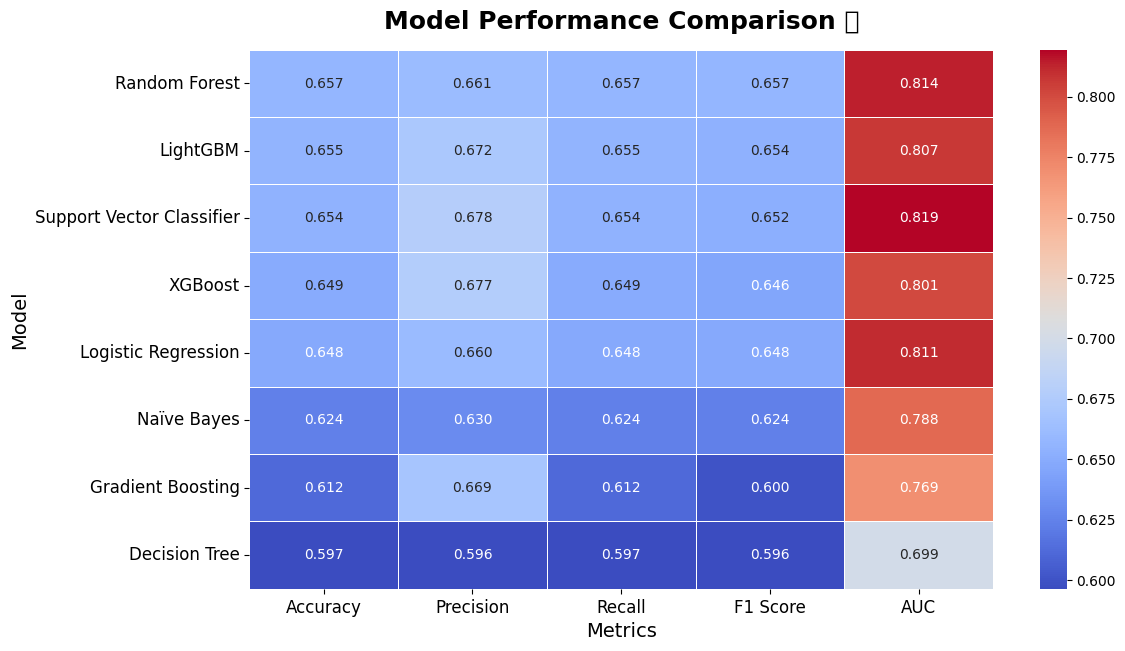

In [23]:
## 🏋️‍♀️ 8. Model Training, Evaluation, and Visualization with Real-Time Updates 🌟

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb
import lightgbm as lgb
from tqdm import tqdm  # For progress tracking
import seaborn as sns
import matplotlib.pyplot as plt

# List of models
models = [
    ('Logistic Regression', LogisticRegression()),
    ('Naïve Bayes', BernoulliNB()),
    ('Support Vector Classifier', SVC(probability=True)),
    ('Random Forest', RandomForestClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('XGBoost', xgb.XGBClassifier(eval_metric='mlogloss')),
    ('LightGBM', lgb.LGBMClassifier())
]

# Create an empty list to store results
results = []

# Loop through models with tqdm progress bar
for model_name, model in tqdm(models, desc="🔄 Training Models"):
    print(f"🛠️ Training Model: {model_name}")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')
    
    # Append the results to the list
    results.append([model_name, accuracy, precision, recall, f1, auc])

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])

# Sort the results by Accuracy
results_df_sorted = results_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# Visualize results in a heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(results_df_sorted.set_index('Model'), annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)
plt.title('Model Performance Comparison 📊', fontsize=18, weight='bold', pad=15)
plt.ylabel('Model', fontsize=14)
plt.xlabel('Metrics', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.show()


<a id="toc"></a>

<a href="#toc" style="background-color: #00a4f9; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a>

---
<p style="font-size:20px; font-family:verdana; line-height: 1.7em; color:#00a4f9;">
    <em>Appreciate your time exploring my work. If you enjoyed it, kindly consider upvoting or feel free to drop comment / feedback to help enhance the notebook. Happy Learning!</em>
</p>


<center><img src='https://mir-s3-cdn-cf.behance.net/project_modules/1400/dea3c9102507757.5f3adfd3a2781.gif' 
     height=100px width=300px /></center>

# Author ✍️: Maimunul Karim Jisan

### 🎓 Education
**Graduated from:** East Delta University, Bangladesh

---

### 🌟 About Me
I am an aspiring data scientist with a strong interest in machine learning and data analysis. My passion lies in exploring innovative solutions to complex problems, and I continually strive to enhance my skills in this dynamic field.

---

### 📫 Connect with Me
- [LinkedIn Profile](https://www.linkedin.com/in/maimunul-karim-jisan-6371a7140/) 
- [GitHub Profile](https://github.com/maimunul)  

---
